In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [8]:
df["category_name"] = df["product_category_tree"].str.split(r">>", regex=False, expand=True)[0]
df["category_name"] = df["category_name"].str.replace('["', '')
df = df[['description', 'category_name']].dropna(subset=['description', 'category_name'])

In [9]:
df['category_name'].value_counts()

,count
category_name,
Home Furnishing,150
Baby Care,150
Watches,150
Home Decor & Festive Needs,150
Kitchen & Dining,150
Beauty and Personal Care,150
Computers,150


In [12]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
from sklearn.ensemble import RandomForestClassifier

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy().squeeze()

# Encoder toutes les descriptions
df['description_vector'] = df['description'].apply(encode_text)

# Préparer les données d'entraînement et les étiquettes
X = np.vstack(df['description_vector'].values)
y = df['category_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBert

RandomForestClassifier(random_state=42)

Précision du modèle sur les données de test : 0.88
                                           description  \
948  Arabian Nights Soex Cranberry Assorted Hookah ...   
971  Key Features of Sparklings Cotton Geometric Do...   
395  Flipkart.com: Buy Nike Orange Combo Set online...   
803  Buy Rega IT Hp Pavilion G6-1240SG G6-1241EA (6...   
733  Buy Canon Toner Cartridge 416 Black only for R...   
134  Buy Rajesh Digital BEST DAD 107 Ceramic Mug fo...   
922  Buy Agrasen International Radha Krishna Statue...   
179  Rockmantra Beautiful Girl With Big Feather Hat...   
582  Flippd FD040149 Casual Analog Watch  - For Wom...   
782  Perucci Pc-122 & Pc-126 Decker Analog Watch  -...   

                   category_name             category_predict  
948  Home Decor & Festive Needs   Home Decor & Festive Needs   
971                   Baby Care                    Baby Care   
395    Beauty and Personal Care     Beauty and Personal Care   
803                   Computers                    Com

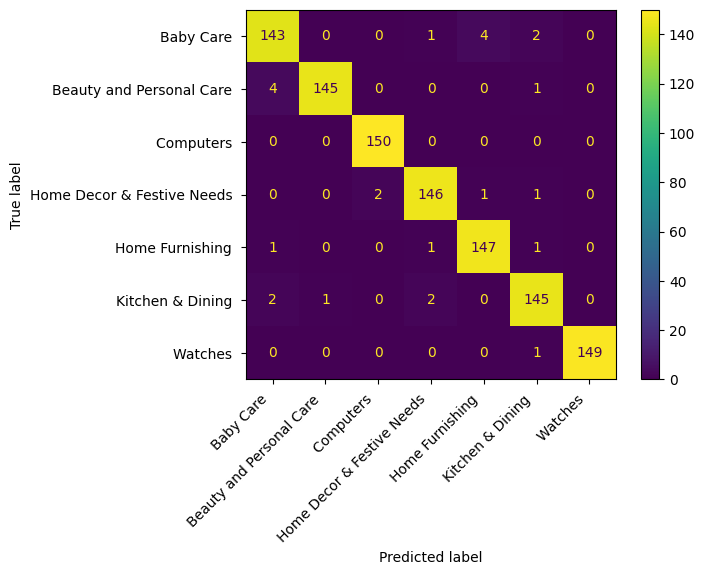

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Faire des prédictions et évaluer le modèle
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle sur les données de test : {accuracy:.2f}")

# Prédire les catégories sur l'ensemble du dataset
df['category_predict'] = clf.predict(np.vstack(df['description_vector'].values))

# Afficher un échantillon de prédictions pour vérifier
print(df[['description', 'category_name', 'category_predict']].sample(10))

# Calculer la précision globale et afficher les erreurs
accuracy = (df['category_name'] == df['category_predict']).mean()
print(f"Précision globale du modèle : {accuracy:.2f}")

# Afficher les erreurs
errors = df[df['category_name'] != df['category_predict']]
print("Nombre d'erreurs :", len(errors))
print(errors[['description', 'category_name', 'category_predict']].head(10))

# Rapport de classification
print(classification_report(df['category_name'], df['category_predict']))

# Afficher la matrice de confusion avec les étiquettes inclinées
disp = ConfusionMatrixDisplay.from_predictions(df['category_name'], df['category_predict'])
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**IMAGE CLASSIFICATION**

In [68]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Charger les données depuis le CSV
data_path = '/content/drive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
data = pd.read_csv(data_path)

# Extraire les chemins d'images et les catégories
data['image_path'] = '/content/drive/MyDrive/Flipkart/Images/' + data['image']
data['category'] = data['product_category_tree'].apply(lambda x: eval(x)[0].split(" >> ")[0])
data["category"] = data["category"].str.replace('["', '')

# Paramètres de l'image et du modèle
img_height, img_width = 224, 224
batch_size = 16

# Préparation des données avec des augmentations d'images
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur pour l'entraînement et la validation
train_generator = datagen.flow_from_dataframe(
    data,
    x_col='image_path',
    y_col='category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    data,
    x_col='image_path',
    y_col='category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Charger ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True

# Construire le modèle
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [ ]:
# Calcul des poids de classe
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Callback pour le taux d'apprentissage
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraîner le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[lr_reduction]  # Ajouter le callback
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 712s 13s/step - accuracy: 0.1599 - loss: 4.6576 - val_accuracy: 0.1346 - val_loss: 4.6239 - learning_rate: 1.0000e-04
Epoch 2/10
 1/52 ━━━━━━━━━━━━━━━━━━━━ 7:56 9s/step - accuracy: 0.3750 - loss: 4.0364

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 371ms/step - accuracy: 0.3750 - loss: 4.0364 - val_accuracy: 0.0000e+00 - val_loss: 4.5140 - learning_rate: 1.0000e-04
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 584s 11s/step - accuracy: 0.3371 - loss: 4.1640 - val_accuracy: 0.1250 - val_loss: 5.0195 - learning_rate: 1.0000e-04
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5625 - loss: 3.8344 - val_accuracy: 0.5000 - val_loss: 4.5046 - learning_rate: 1.0000e-04
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 671s 12s/step - accuracy: 0.4838 - loss: 3.8229 - val_accuracy: 0.0721 - val_loss: 4.8448 - learning_rate: 1.0000e-04
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5000 - loss: 4.0449 - val_accuracy: 0.0000e+00 - val_loss: 5.5599 - learning_rate: 1.0000e-04
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 611s 12s/step - accuracy: 0.5738 - loss: 3.6048 - val_accuracy: 0.0433 - val_loss: 4.9341 - learning_rate: 1.0000e-04
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.437

In [ ]:
# Évaluation du modèle
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Précision sur les données de validation : {val_accuracy:.2f}")

# Prédictions et analyse
y_pred_proba = model.predict(validation_generator)
y_pred_classes = y_pred_proba.argmax(axis=1)

class_labels = list(train_generator.class_indices.keys())
y_true = validation_generator.classes

# Rapport de classification
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matrice de confusion
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes, display_labels=class_labels)
plt.xticks(rotation=45, ha='right')
plt.show()

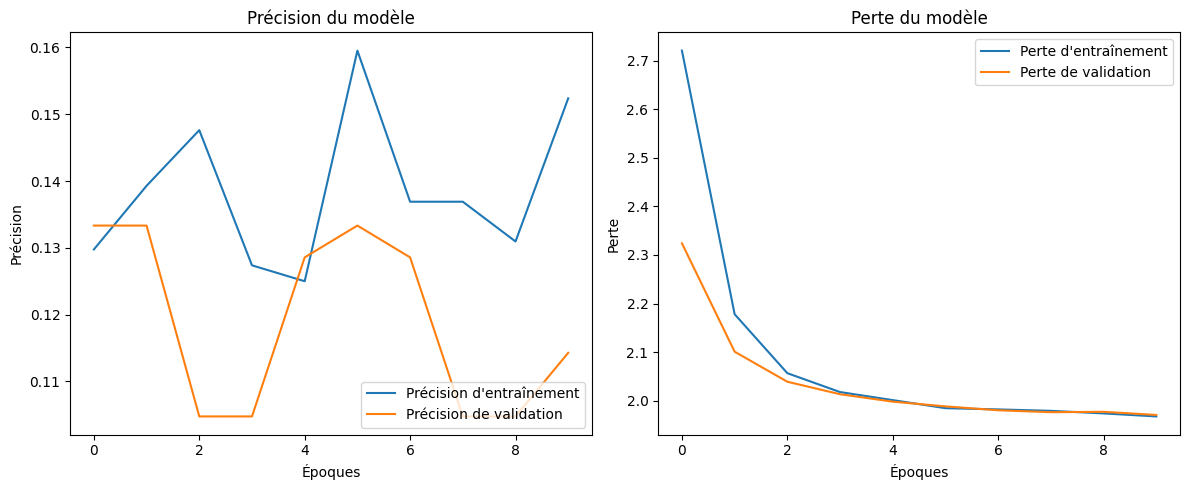

In [27]:
import matplotlib.pyplot as plt

# Tracer la précision
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.title('Précision du modèle')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend(loc='lower right')

# Tracer la perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Perte du modèle')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Évaluation du modèle sur les données de validation
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Précision sur les données de validation : {val_accuracy:.2f}")

# Prédictions sur les données de validation
y_pred = model.predict(validation_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Récupérer les étiquettes des classes
class_labels = validation_dataset.class_names  # Utiliser validation_dataset pour obtenir les noms de classes
y_true = np.concatenate([y for x, y in validation_dataset])  # Obtenir les vraies étiquettes à partir de validation_dataset

# Rapport de classification
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes, display_labels=class_labels)
plt.xticks(rotation=45, ha='right')
plt.title('Matrice de confusion')
plt.show()

**Multi inputs, combinaison des deux modèles**

In [26]:
from sklearn.preprocessing import LabelEncoder

# Création du modèle combiné
text_model_output = tf.keras.layers.Input(shape=(768,), name='text_input')  # La taille du vecteur de DistilBERT est 768
image_model_output = tf.keras.layers.Input(shape=(img_size[0], img_size[1], 3), name='image_input')

# Passer l'entrée d'image à EfficientNet
base_output = base_model(image_model_output)

# Aplatir la sortie d'EfficientNet
base_output_flat = layers.Flatten()(base_output)

# Fusion des sorties
x_combined = layers.Concatenate()([text_model_output, base_output_flat])

# Ajout de couches supplémentaires pour le modèle de fusion
x_combined = layers.Dense(128, activation='relu')(x_combined)
x_combined = layers.Dropout(0.2)(x_combined)
final_output = layers.Dense(train_dataset.cardinality().numpy(), activation='softmax')(x_combined)  # Nombre de classes

# Construction du modèle combiné
combined_model = Model(inputs=[text_model_output, image_model_output], outputs=final_output)

# Compilation du modèle combiné
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Préparer les données d'entraînement et de validation en tant que tableaux NumPy
X_image_train = np.concatenate([x.numpy() for x, _ in train_dataset])
y_image_train = np.concatenate([y.numpy() for _, y in train_dataset])

X_image_val = np.concatenate([x.numpy() for x, _ in validation_dataset])
y_image_val = np.concatenate([y.numpy() for _, y in validation_dataset])

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Entraîner le modèle combiné
combined_model.fit(
    [X_train, X_image_train],  # Entrées : vecteurs de texte et tableaux d'images
    y_train_encoded,  # Utiliser les étiquettes encodées
    validation_data=([X_test, X_image_val], y_test_encoded),  # Validation avec les données de validation
    epochs=10  # Vous pouvez ajuster le nombre d'époques
)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.1266 - loss: 5.6944 - val_accuracy: 0.1429 - val_loss: 2.7411
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.1340 - loss: 2.8663 - val_accuracy: 0.1571 - val_loss: 2.7560
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.1344 - loss: 2.7221 - val_accuracy: 0.1571 - val_loss: 2.5659
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.1523 - loss: 2.6125 - val_accuracy: 0.0905 - val_loss: 2.2403
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.1219 - loss: 2.3383 - val_accuracy: 0.2000 - val_loss: 2.1561
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.1403 - loss: 2.2706 - val_accuracy: 0.1000 - val_loss: 1.9778
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.1725 - loss: 2.2368 - val_accuracy: 0.2667 - val_loss: 1.9978
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.2082 - loss: 2.1204 - val_accuracy: 0.1619 - val_loss:

In [28]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = combined_model.evaluate([X_test, X_image_val], y_test_encoded)

print(f'Perte sur l\'ensemble de test : {test_loss:.4f}')
print(f'Précision sur l\'ensemble de test : {test_accuracy:.4f}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.1491 - loss: 1.9264
Perte sur l'ensemble de test : 1.9233
Précision sur l'ensemble de test : 0.1571


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


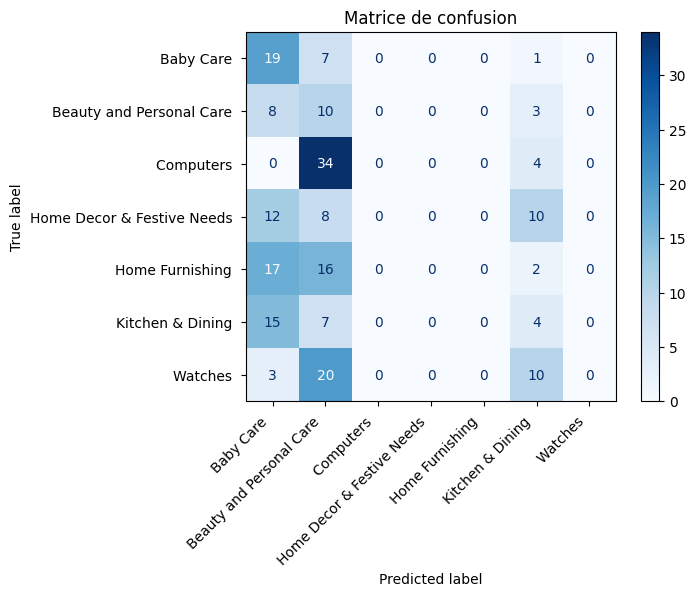

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédire les étiquettes pour l'ensemble de test
y_pred = combined_model.predict([X_test, X_image_val])
y_pred_classes = np.argmax(y_pred, axis=1)

# Créer une matrice de confusion
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


In [30]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
report = classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_)
print(report)


                             precision    recall  f1-score   support

                 Baby Care        0.26      0.70      0.38        27
  Beauty and Personal Care        0.10      0.48      0.16        21
                 Computers        0.00      0.00      0.00        38
Home Decor & Festive Needs        0.00      0.00      0.00        30
           Home Furnishing        0.00      0.00      0.00        35
          Kitchen & Dining        0.12      0.15      0.13        26
                   Watches        0.00      0.00      0.00        33

                   accuracy                           0.16       210
                  macro avg       0.07      0.19      0.10       210
               weighted avg       0.06      0.16      0.08       210



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
